# Project Overview:

About 1 million adults in the US seek care in a hospital due to pneumonia every year, and 50,000 die from this disease. Pneumonia is an infection of the lungs and it is the world’s leading cause of death among children under 5 years of age. In developing nations, pneumonia can be further aggravated due to the dearth of medical resources and personnel.  For vulnerable populations, an accurate and fast diagnosis means everything. To overcome this problem, a neural network model is introduced to automatically perform fast and accurate classification using a deep neural network architecture. The CNN (Convolutional neural network) is a special type of neural networks that can automatically extract features from images. CNN-based deep learning algorithms have become the standard choice for medical image classification. With the help of the introduced CNN model, our implementation of a diagnostic tool is presented for the screening of patients with pneumonia. Optimizing diagnosis procedures of vulnerable patients will significantly improve the probability of faster recovery. 

# Problem Statement:
Pneumonia is an infection that inflames the air sacs in one or both lungs. It results in difficulty in breathing due to the air sacs filling with fluid. Pneumonia can be very serious for infants and young children. Patients older than age 65 or with existing conditions are also at risk of complications from pneumonia. Symptoms from pneumonia include chest pain when breathing, confusion, cough, fatigue, fever, nausea, and shortness of breath. Pneumonia is a common condition and is easily diagnosed using medical imaging. The Institute of Medicine at the National Academies of Science, Engineering, and Medicine reports that “diagnostic errors contribute to approximately 10 percent of patient deaths”. Additionally, 6 to 17 percent of hospital complications are also the result of incorrect diagnosis. Not only diagnostic errors can affect the recovery of a patient, but the availability of health care personnel is also an issue in developing countries. To address this problem, researchers and companies are levering deep learning to improve medical diagnostics. The adoption and standardization of machine learning in the health industry is expected to improve the likelihood of correct diagnosis and prioritize treatment. Manual observation of images has remained relatively unchanged for over a century. The application of machine learning has the potential to impact how health care systems approach diagnostics and the availability of rapid diagnosis and therefore faster treatment. Even though Artificial intelligence in medical diagnostics is still a relatively new approach it shows a great promise. Some advances have been made to support the adoption of AI algorithms in the healthcare industry. The Food and Drug Administration has approved more than 30 AI algorithms for use in healthcare to date. Furthermore, AI algorithms will support critical steps in the early detection of diseases and the prioritization of treatment. The more optimal distribution of the healthcare personnel is key in revolutionizing the modern healthcare sector. AI adoption by the health industry will have a significant impact on traditional procedures improving diagnosis speed and possibly correctness for pneumonia and other diseases.

More on Machine Learning on Medical field: <br>
https://emerj.com/ai-sector-overviews/machine-learning-medical-diagnostics-4-current-applications/ <br>
https://hms.harvard.edu/news/better-together <br>
https://www.thoracic.org/patients/patient-resources/resources/top-pneumonia-facts.pdf<br>
https://www.healthcaredive.com/news/ai-just-as-effective-as-clinicians-in-diagnostics-study-suggests/563605/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset
import random

import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Initial Data Exploration

We will first like to explore our data by displaying the images we will be looking at. Below we will look at a normal patient and a Pneumonia patient and see if we can spot the difference with an untrained eye.

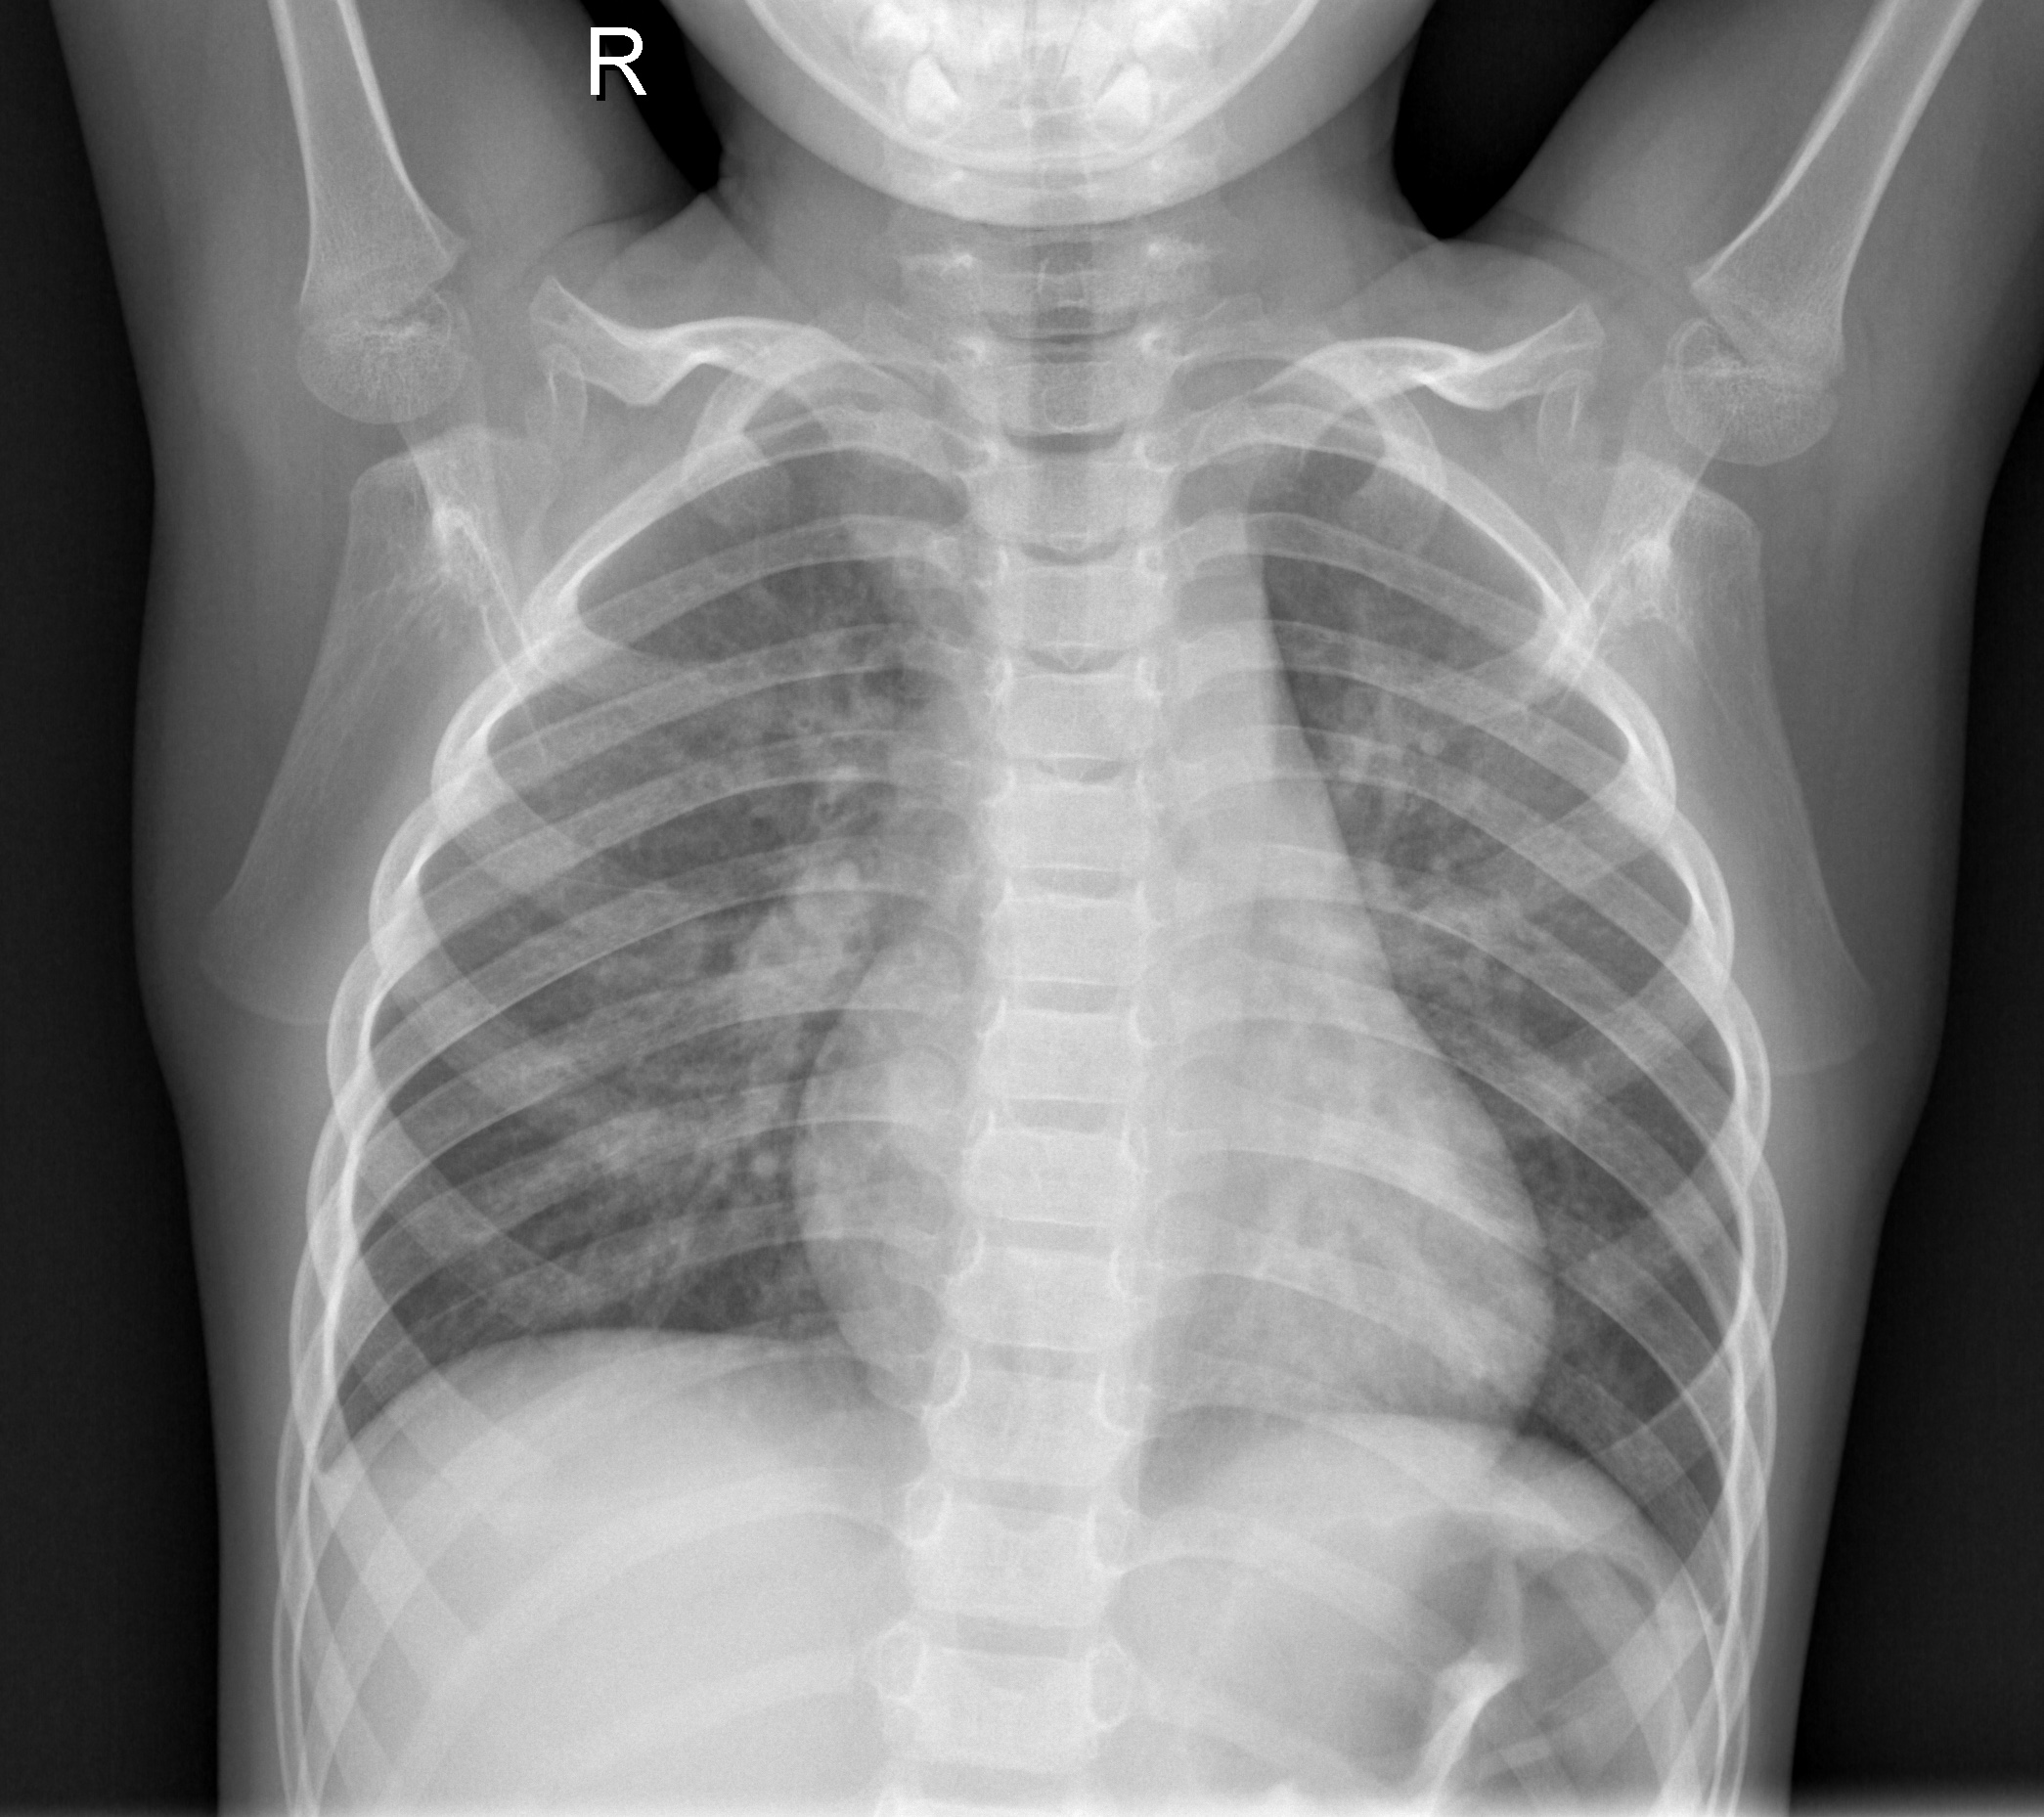

In [2]:
with Image.open('../Data/chest_xray/train/NORMAL/IM-0115-0001.jpeg') as im:
    display(im)

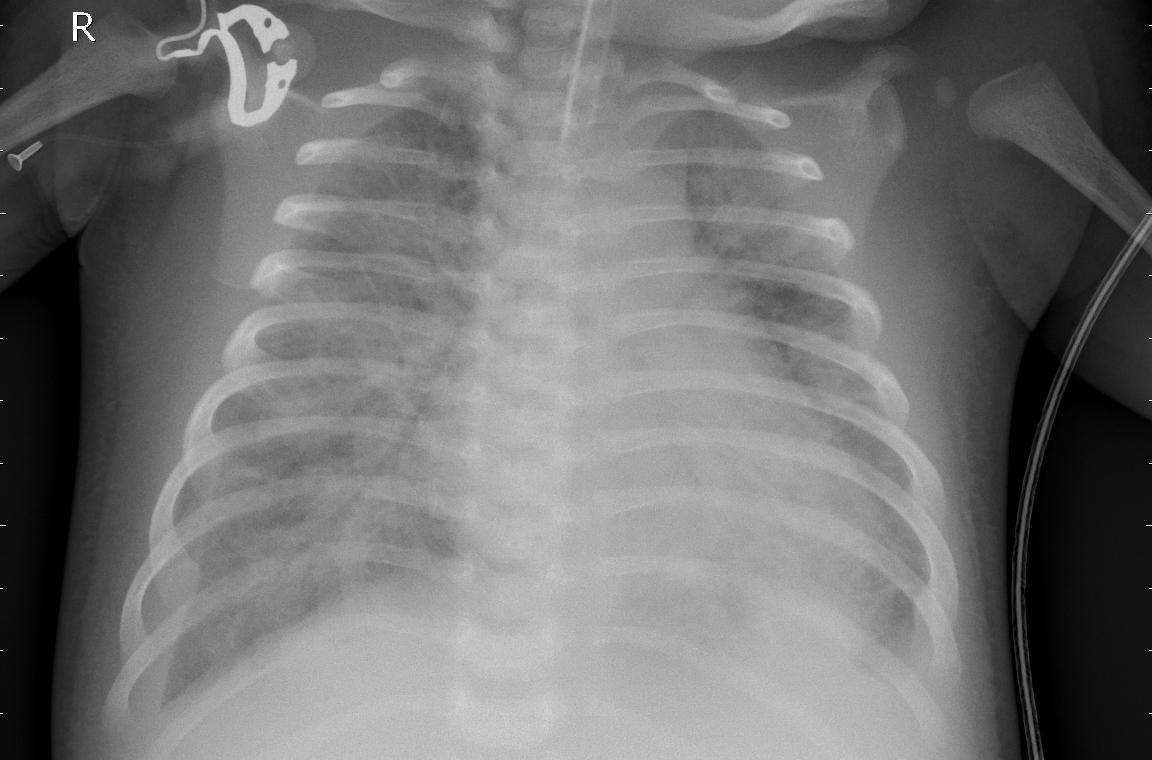

(1152, 760)


In [3]:
with Image.open('../Data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg') as im :
    display(im)
    print(im.size)

### Data analysis

In the following snippets of code, we will explore our data. We will see how much data we have, and then explore there images' sizes. We will also be using the Pandas library to see our dataset easier and also let Pandas describe our dataset so we can see information such as the mean and standard deviation of the carrying image sizes.

In [4]:
# Location of the images in my current machine
root = '../Data/chest_xray/'
img_names = []

for folders,subfolders,filenames in os.walk(root):
    for img in filenames:
        img_names.append(folders+ "/" + img)

In [5]:
len(img_names)

5864

In [6]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    
    except:
        rejected.append(item)

In [7]:
df = pd.DataFrame(img_sizes)

In [8]:
df

0     1
0     1857  1317
1     2111  1509
2     2031  1837
3     1663  1326
4     2053  1818
...    ...   ...
5851  1416   944
5852  1256   864
5853  1016   656
5854  1192   952
5855  1664  1128

[5856 rows x 2 columns]

**See the info about the images' height in the data**

In [9]:
df[0].describe()

count    5856.000000
mean     1327.880806
std       363.500922
min       384.000000
25%      1056.000000
50%      1281.000000
75%      1560.000000
max      2916.000000
Name: 0, dtype: float64

**See the info about the images' width in the data**

In [10]:
df[1].describe()

count    5856.000000
mean      970.689037
std       383.392117
min       127.000000
25%       688.000000
50%       888.000000
75%      1187.000000
max      2713.000000
Name: 1, dtype: float64

**Combine we can see the general info of the height * width of the data**

In [11]:
df.describe()

0            1
count  5856.000000  5856.000000
mean   1327.880806   970.689037
std     363.500922   383.392117
min     384.000000   127.000000
25%    1056.000000   688.000000
50%    1281.000000   888.000000
75%    1560.000000  1187.000000
max    2916.000000  2713.000000

### Preprocessing Data

As you can see from the analysis using pandas we have many images with varying degrees of sizes. To perform a convolutional neural network we would make sure that all images are the same size in both height and width. In the following block of code, we will be creating a function that will be used to transform the data to Tensors that will also modify the images to the way we see fit. Then we will further be analyzing our data.



#### Image Normalization

Normalization is a technique often applied as part of data preparation for machine learning. The goal is to change the numeric values of the dataset to a common scale without distorting the difference in the ranges of value. But every dataset does not necessarily require normalization. We used the Mean and Standard deviation of ImageNet to normalize the image data as we will use it further down the line.

More on Normalzition: <br>
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029 <br>
https://arthurdouillard.com/post/normalization/

In [12]:
train_transform = transforms.Compose([
        transforms.Resize(244),             # resize shortest side to 244 pixels
        transforms.CenterCrop(244),         # crop longest side to 244 pixels at center
        transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
        transforms.Resize(244),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
    ])

In [13]:
# tranforming our data to Tensors 
train_data = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform=test_transform)

**Here we can see how much training and testing images we have available to us in this data set**

In [14]:
class_names = train_data.classes
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Training images available: 5216
Testing images available:  624


**The DataLoader function is used to create batches and let us iterate through it so when we perform the Deep Neural Network
we can update the weights more frequently rather than one big chunk to converge quicker to our ideal weights**

In [15]:
train_loader = DataLoader(train_data,batch_size=16,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=16,shuffle=False, pin_memory=True)

In [16]:
class_names = train_data.classes
print(class_names)
print(f'Training loaders available: {len(train_loader)}')
print(f'Testing laoder available:  {len(test_loader)}')

['NORMAL', 'PNEUMONIA']
Training loaders available: 326
Testing laoder available:  39


In [17]:
def showImg(im, inv=False):
    if inv == False:
        plt.figure(figsize=(24,12))
        plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    else:
        inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                             std=[1/0.229, 1/0.224, 1/0.225])
        im_inv = inv_normalize(im)
        plt.figure(figsize=(24,12))
        plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Label: [1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1]
Class: PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA


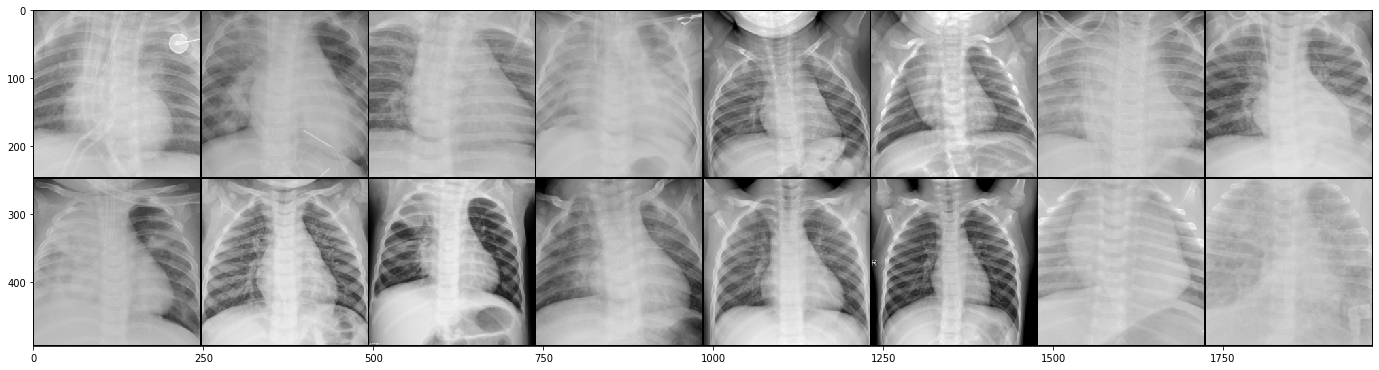

In [18]:
# Grab the first batch of 16 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=8)  # the default nrow is 8

# Print the images (Left to right)
showImg(im)

**Now we have finished exploring the initial data exploration and obviously, with the untrained eye we cannot tell the difference between a patient with or without Pneumonia we will see how our first model will perform on classifying an image with or without Pneumonia**

## The model

We will start building the Fully connected convolutional neural network (CNN) model. We will first explain how each function work and the results of it and then start actually building the model. Below is an image of how a typical Fully connected layer looks like.

![title](../images/FcCNN.png)

### Convolution

The first thing to understand is how convolution works. It is basically a moving window or filter called a kernel that strides over an image. This moving window applies a mathematical calculation to create another matrix that holds the information for each kernel movement. Below you can see a basic representation of how convolution functions. This is a kernel size of 2x2 with a stride of 1.

![title](../images/Moving-filter.jpg)

After going through convolution the next step is to pass the output through a non-linear activation function such as ReLU. This will provide the standard non-linear behavior that neural networks have. This process is also known as feature mapping.



### Max pooling

Pooling is another sliding window type technique, but instead of applying weights, that can be trained, it applies statistical functions of some type over the contents of its window. In **Max Pooling** it is getting the highest signal in the kernel. The main benefits of pooling in CNN are that it reduces the number of parameters in the model also known as down-sampling, so reduces run time. Also, it makes feature detection more robust to object orientation and scale changes. Below is an example of max pooling with a kernel size of 2x2 and a stride of 2.

![title](../images/Max-pooling.jpg)

More on Convolution and pooling: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

### The Fully Connected Layer

The role of the fully connected layer on CNN is to take the results of the convolution and pooling process and use them to classify the image into a label. The output of the convolution/pooling is first flattened into a single vector of values and then performs its feedforward and backpropagation algorithm to update the weights in the model and improve the weights of the model to learn the data. Below is an image of a fully connected network after the convolution/pooling process.

![title](../images/FCN.png)

More on Fully Connected Convolutional Neural Networks: <br> https://missinglink.ai/guides/convolutional-neural-networks/fully-connected-layers-convolutional-neural-networks-complete-guide/

In [19]:
# Here we have a batch of data with 16 images and the 3  color channels Red,Green,Blue that are 128 by 128
images.shape

torch.Size([16, 3, 244, 244])

In [20]:
conv = nn.Conv2d(3, 8, 3, 1) # input channels, amount of kernel to randomly create, kernel size (3x3), the stride=1
for x,labels in train_loader:
    print('Orig size:',x.shape)
    break
x = conv(x)
print('Down size:',x.shape)

Orig size: torch.Size([16, 3, 244, 244])
Down size: torch.Size([16, 8, 242, 242])


In [21]:
x = F.max_pool2d(x, 2, 2) # input data, kernel size (2x2), stride=2
print('Down size:',x.shape)

Down size: torch.Size([16, 8, 121, 121])


In [22]:
conv = nn.Conv2d(8, 16, 3, 1) # input this time is the amount of kernel from previous convolution, 8 random kernels, kernel size(3x3),
                             # and stride = 1
x = conv(x)
print('Down size:',x.shape)

Down size: torch.Size([16, 16, 119, 119])


In [23]:
x = F.max_pool2d(x, 2, 2) # input channels, amount of kernel to randomly create, kernel size (3x3), the stride=1
print('Down size:',x.shape)

Down size: torch.Size([16, 16, 59, 59])


In [24]:
conv = nn.Conv2d(16, 32, 3, 1) # input this time is the amount of kernel from previous convolution, 8 random kernels, kernel size(3x3),
                             # and stride = 1
x = conv(x)
print('Down size:',x.shape)

Down size: torch.Size([16, 32, 57, 57])


In [25]:
x = F.max_pool2d(x, 2, 2) # input channels, amount of kernel to randomly create, kernel size (3x3), the stride=1
print('Down size:',x.shape)

Down size: torch.Size([16, 32, 28, 28])


### Activation Functions

The activation functions in Neural networks are an important component in deep learning. Activation functions are mathematical equations applied to each neuron to produce an output. They determine the output of a deep learning model, its accuracy, and also the computational efficiency of the training model. They are also the ones that impact in converging for the model. Activation functions are what make or breaks neural networks. Activation functions are mathematical equations applied to each neuron to produce an output. 

#### ReLU

The Rectified Linear Unit is an activation function which mathematical equation is ***y = max(0,x)***. It is one of the most commonly used activation function mainly because it is cheap to compute as it is only grabbing the biggest value and if is 0 or less it sets it to zero, it typically converges faster due to its linearity, since ReLU is 0 for all negative value it is sparsely activated which is usually a desirable property we want from some neurons. 

The main downside of ReLU is that when inputs approach zero the network cannot perform backpropagation anymore and cannot learn anymore thus the model cannot learn anymore.

**ReLU function:**
![title](../images/ReLU.png)

#### Softmax function 
The softmax function is to be able to handle multiple classes (Normal and Pneumonia in this case). It does this by normalizing the outputs for each class from 0 to 1 and then divides by their sum, giving the probability of the input value being in a specific class. This activation function was chosen for the output layer because although this is only two classes that can probably be done with other methods through binary cross-entropy, we want to show that even though this classifies images with the Pneumonia symptom we want to see what are the probability it is. Since the model will never be perfect knowing that the analysis of the image shows a probability of a 20% chance of being Normal and 80% of being Pneumonia can be very important for doctors using such an approach to diagnose a patient. 

![title](../images/softmax.png)

More on Activation Functions: <br>
https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/ <br>
https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Sequential(nn.Linear(28*28*32, 1028),
                                        nn.ReLU(),
                                        nn.Linear(1028, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,2))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*32)
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)

### Loss Function and Optimizer

#### Cross Entropy Loss (Log Loss)
The loss function we will be using is the Cross-Entropy function for very simple reasons. The Cross-entropy loss measures the performance of a classification model whose outputs are a probability value between 0 and 1. So it works perfectly well with our softmax function has it produces a vector of numbers between the number from 0 to 1.


#### Optimizer
During the training process, we tweak and change the weights of our model through our loss function. We want to minimize the output of the loss function, and slowly make our predictions better. but how much do we change the weights is very important as we don't want the weights to go haywire and never converge to a good prediction. This is where the optimizer comes in, they tie together the loss function and model parameters through updating the weights in the right direction. This is what helps gradient descent converge to the closest or the lowest cost value.

We will be using Adam which is an adaptive learning rate optimizer algorithm that was designed specifically for training deep neural networks and will be using the traditional value of 0.01 for its learning rate.

More on Cross-Entropy: <br>
https://machinelearningmastery.com/cross-entropy-for-machine-learning/ <br>
https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

More on  Optimizer: <br>
https://algorithmia.com/blog/introduction-to-optimizers <br>
https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c

Adam publication : <br> https://arxiv.org/abs/1412.6980

In [27]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=25088, out_features=1028, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1028, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [28]:
# number of parameters
total=0
for p in model.parameters():
    total += p.numel()
    print(p.numel())
total

216
8
1152
16
4608
32
25790464
1028
526336
512
1024
2


26325398

### Training on GPU
design for extensive graphical and mathematical computations that helps alleviate the workload on the CPU. The main reason GPU is very important hardware is that it was basically designed for computing matrix calculations very efficiently which is what Deep Learning is when it comes to the calculation run in the code.

The three core comparison between training on CPU vs GPU comes down to this:
* Training a model in deep learning requires a huge amount of Datasets, thus a large amount of memory is needed for large computational operations.
* GPU performs all this large computational in parallel. Not saying CPU does not work in parallel, but GPU has much more parallelism. For example in my current machine, my CPU the Ryzen 5 2600 has 6 cores and 12 threads, meaning we can have at least 12 processes running to perform computation. But compare to my GPU the RTX2070 Super with 2560 CUDA cores to do computational analysis. 
* Latency on GPU is very low compare to CPU. Thus GPU bandwidth is very high under thread parallelism hence GPU would be the better choice for deep learning models

Below is a representation of how well GPU performs compare to server-level CPU.

![title](../images/gpu-floating.png)

**We will be training on gpu to accelerate the run time process of the model this is not necessary for this project.** <br>
You can see the benefits of GPU for deep learning here: <br> 
https://medium.com/@shachishah.ce/do-we-really-need-gpu-for-deep-learning-47042c02efe2 <br>
https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d

In [29]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 

In [30]:
dev

'cuda:0'

In [31]:
device = torch.device(dev)  

In [32]:
model = model.to(dev)

In [33]:
start_time = time.time()

epochs = 8 # number of iterations to train for
train_losses = [] # keep track of all train losses
test_losses = [] # keep track of all test losses
train_correct = [] # keep count on how many corrects prediction is done with the traiting batches
test_correct = [] # keep count on many corrects prediction is done with the traiting batches

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Move the data to gpu if available
        X_train = X_train.to(dev)
        y_train = y_train.to(dev)
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch results
        if b%163 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{16*b:6}/5216]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(16*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            X_test = X_test.to(dev)
            y_test = y_test.to(dev)
            
            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  163 [  2608/5216]  loss: 0.62813085  accuracy:  73.313%
epoch:  0  batch:  326 [  5216/5216]  loss: 0.50401670  accuracy:  73.792%
epoch:  1  batch:  163 [  2608/5216]  loss: 0.56279004  accuracy:  73.811%
epoch:  1  batch:  326 [  5216/5216]  loss: 0.75012112  accuracy:  74.291%
epoch:  2  batch:  163 [  2608/5216]  loss: 0.63284564  accuracy:  74.885%
epoch:  2  batch:  326 [  5216/5216]  loss: 0.62284583  accuracy:  74.291%
epoch:  3  batch:  163 [  2608/5216]  loss: 0.39754009  accuracy:  73.505%
epoch:  3  batch:  326 [  5216/5216]  loss: 0.82849407  accuracy:  74.291%
epoch:  4  batch:  163 [  2608/5216]  loss: 0.33588278  accuracy:  74.847%
epoch:  4  batch:  326 [  5216/5216]  loss: 0.68857604  accuracy:  74.291%
epoch:  5  batch:  163 [  2608/5216]  loss: 0.49944133  accuracy:  74.923%
epoch:  5  batch:  326 [  5216/5216]  loss: 0.49146506  accuracy:  74.291%
epoch:  6  batch:  163 [  2608/5216]  loss: 0.62338430  accuracy:  74.233%
epoch:  6  batch:  326 [ 

## Analyzing results 1

Now that the model has finish training we can see the results. Now the metrics that we will look closely into is the accuracy and the loss at each epoch of the model.

### Loss

So below are the results of the Cross-Entropy Loss in the end of each epoch as you can see it is a relatively small numbers but typically we want the training loss and testing loss to be as low as possible and for both of them to be about the same as this correlates to how well our model performs with random new data set.

In [80]:
train_losses

[tensor(0.0436, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0519, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0180, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.1111, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.1131, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.1998, device='cuda:0', grad_fn=<NllLossBackward>)]

In [81]:
test_losses

[tensor(0.0272, device='cuda:0'),
 tensor(0.0061, device='cuda:0'),
 tensor(0.0068, device='cuda:0'),
 tensor(0.0085, device='cuda:0'),
 tensor(0.0007, device='cuda:0'),
 tensor(0.0052, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor(0.0007, device='cuda:0')]

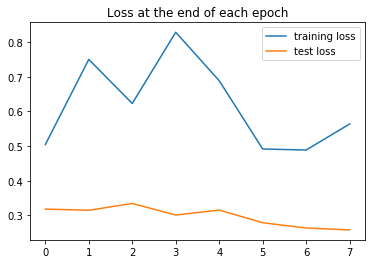

In [34]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend();

### Accuracy

Below we look at how many correct prediction we will see for each epoch in the model. 

**Looking at how much we have correct in each epoch**

In [82]:
train_correct

[tensor(4793, device='cuda:0'),
 tensor(4961, device='cuda:0'),
 tensor(5003, device='cuda:0'),
 tensor(5035, device='cuda:0'),
 tensor(5027, device='cuda:0'),
 tensor(5057, device='cuda:0'),
 tensor(5074, device='cuda:0'),
 tensor(5083, device='cuda:0')]

In [83]:
test_correct

[tensor(472, device='cuda:0'),
 tensor(469, device='cuda:0'),
 tensor(493, device='cuda:0'),
 tensor(497, device='cuda:0'),
 tensor(503, device='cuda:0'),
 tensor(499, device='cuda:0'),
 tensor(429, device='cuda:0'),
 tensor(490, device='cuda:0')]

**Dividing the total corrects by  the total number of images there are in total for both the train_data(5216) and the test data(624)**

In [86]:
for t in train_correct:
    print(t/float(len(train_data)) )

tensor(0.9189, device='cuda:0')
tensor(0.9511, device='cuda:0')
tensor(0.9592, device='cuda:0')
tensor(0.9653, device='cuda:0')
tensor(0.9638, device='cuda:0')
tensor(0.9695, device='cuda:0')
tensor(0.9728, device='cuda:0')
tensor(0.9745, device='cuda:0')


In [87]:
for t in test_correct:
    print(t/float(len(test_data)) )

tensor(0.7564, device='cuda:0')
tensor(0.7516, device='cuda:0')
tensor(0.7901, device='cuda:0')
tensor(0.7965, device='cuda:0')
tensor(0.8061, device='cuda:0')
tensor(0.7997, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.7853, device='cuda:0')


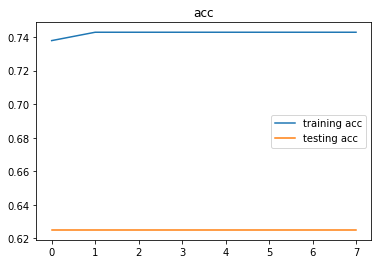

In [35]:
plt.plot([t/float(len(train_data)) for t in train_correct], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct], label='testing acc')
plt.title("acc")
plt.legend()

**From the results of the training accuracy and testing accuracy we can tell that the model is not doing very well in classifying the two types of images in both the training and testing datasets.**

#### Confusion Matrix

A confusion matrix is a table that is often used that describes the performance of a classification model on a set of test data for which the true values are known. This helps us visualize how our model predicted

Test accuracy: 390/624 =  62.500%


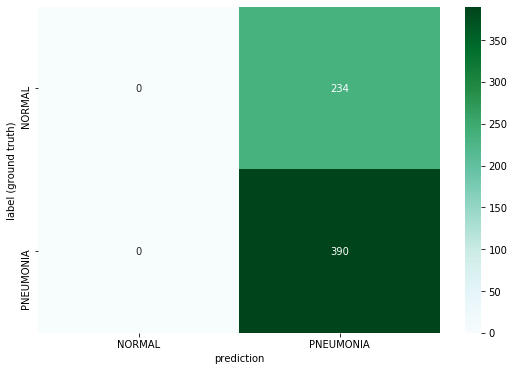

In [36]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
model.eval()
model = model.cpu()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

**As you can see our current model is just predicting that all our images are Pneumonia images and can't find the features that show a sign of Pneumonia in the images. Since it assume all images were Pneumonia it got 62.5% correct because 62.5% of the test images were of Pneumonia**

## Improving the model

### Overfitting
When we run train our model on our current dataset, we allow the overall cost to become smaller with the more iterations or epochs. So over a long span of iterations at one point, it will lead to a minimal overall change of cost. This also means that the line separating the two classes will be fit into all points including the noise in the images, so secondary unnecessary patterns will be picked up by the model that is detrimental to the generalization of the model. 

So seeing as the previous model was overfitting meaning it is learning too much from the training dataset's feature and causes it to not perform well in the testing dataset, we will now look into how to reduce overfitting to increase our accuracy and also close the gap between our training and testing losses.

More on Overfitting: <br>
https://towardsdatascience.com/what-are-overfitting-and-underfitting-in-machine-learning-a96b30864690

**We made the training procedure into a function to have an easier time and a clearer view of our exploratory process**

In [37]:
def runModel(model,criterion,optimizer,train_loader,test_loader,scheduler=None,epochs=8, print_every=163,c=1):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []
    model = model.to(dev)
    for i in range(epochs):
        
        if scheduler==None:
            pass
        else:
            scheduler.step()
        
        trn_corr = 0
        tst_corr = 0
        model.train()
        # Run the training batches
        for b, (X_train, y_train) in enumerate(train_loader):
            b+=1
            
            X_train = X_train.to(dev)
            y_train = y_train.to(dev)
            #print(X_train)
            # Apply the model
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
 
            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr
        
            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            # Print batch results
            if b%print_every == 0:
                print(f'epoch: {i:2}  batch: {b:4} [{16*b:6}/{c*5216}]  loss: {loss.item():10.8f}  \
    accuracy: {trn_corr.item()*100/(16*b):7.3f}%')
        
        train_losses.append(loss)
        train_correct.append(trn_corr)
        
        # Run the testing batches
        with torch.no_grad():
            model.eval()
            for b, (X_test, y_test) in enumerate(test_loader):

                X_test = X_test.to(dev)
                y_test = y_test.to(dev)
            
                # Apply the model
                y_val = model(X_test)

                # Tally the number of correct predictions
                predicted = torch.max(y_val.data, 1)[1] 
                tst_corr += (predicted == y_test).sum()
           
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 
    return train_losses,train_correct,test_losses,test_correct

#### Image Normalization

Normalization is a technique often applied as part of data preparation for machine learning. The goal is to change the numeric values of the dataset to a common scale without distorting the difference in the ranges of value. But every dataset does not necessarily require normalization. We used the Mean and Standard deviation of ImageNet to normalize the image data as we will use it further down the line.

More on Normalzition: <br>
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029 <br>
https://arthurdouillard.com/post/normalization/

In [38]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(244),             # resize shortest side to 224 pixels
        transforms.CenterCrop(244),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # mean use by imagenet for the RGB channel
                             [0.229, 0.224, 0.225]) # standard deviation use by imagenet
    ])

test_transform = transforms.Compose([
        transforms.Resize(244),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [39]:
train_data = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform=test_transform)

In [40]:
train_loader = DataLoader(train_data,batch_size=16,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=16,shuffle=False, pin_memory=True)

In [41]:
# Grab the first batch of 16 images
for images,labels in train_loader: 
    break

**Here is how the images looks like after applying the normalization**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1]
Class: PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA


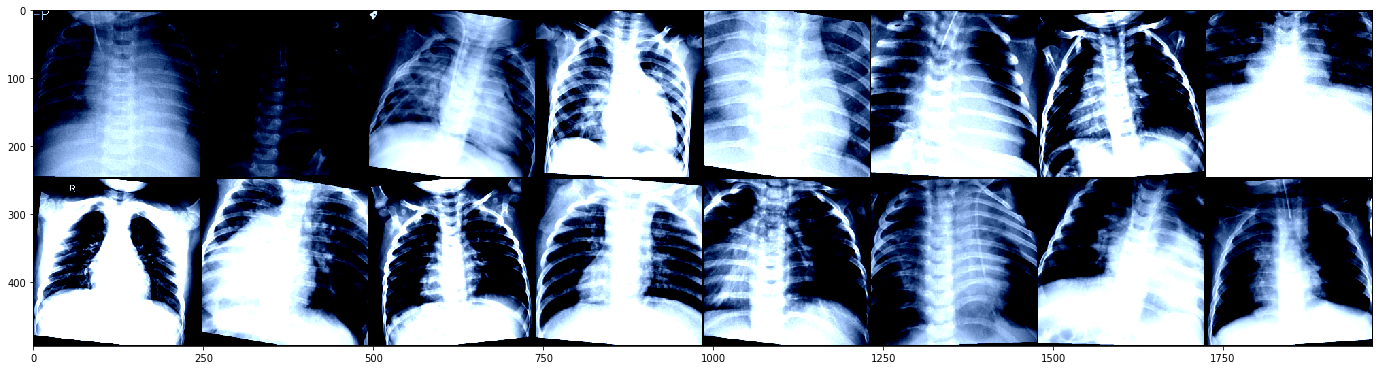

In [42]:
# Grab the first batch of 16 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=8)  # the default nrow is 8

# Print the images (Left to right)
showImg(im,inv=False)

**Here is how the images look when reverted back to their original form**

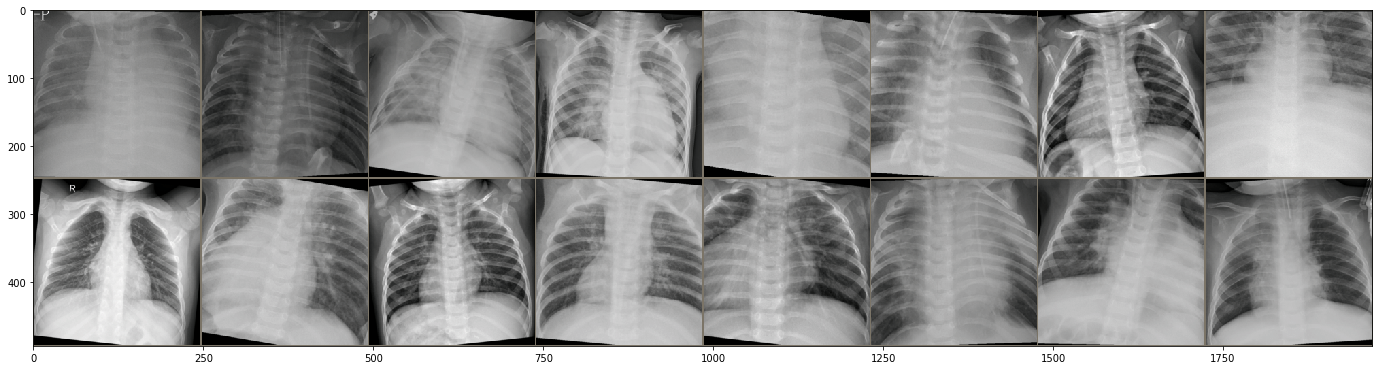

In [43]:
# Print the images (Left to right)
showImg(im,inv=True)

In [44]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=25088, out_features=1028, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1028, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [45]:
train_losses,train_correct,test_losses,test_correct = runModel(model=model,
                                                               criterion=criterion,
                                                               optimizer=optimizer,
                                                               train_loader=train_loader,
                                                               test_loader=test_loader,
                                                               )

epoch:  0  batch:  163 [  2608/5216]  loss: 0.56260699      accuracy:  73.888%
epoch:  0  batch:  326 [  5216/5216]  loss: 0.48503980      accuracy:  74.022%
epoch:  1  batch:  163 [  2608/5216]  loss: 0.35607716      accuracy:  74.540%
epoch:  1  batch:  326 [  5216/5216]  loss: 0.40241787      accuracy:  74.291%
epoch:  2  batch:  163 [  2608/5216]  loss: 0.41606715      accuracy:  74.885%
epoch:  2  batch:  326 [  5216/5216]  loss: 0.69405615      accuracy:  74.367%
epoch:  3  batch:  163 [  2608/5216]  loss: 0.38267851      accuracy:  74.540%
epoch:  3  batch:  326 [  5216/5216]  loss: 0.32082826      accuracy:  74.291%
epoch:  4  batch:  163 [  2608/5216]  loss: 0.56233758      accuracy:  75.192%
epoch:  4  batch:  326 [  5216/5216]  loss: 0.70501792      accuracy:  74.291%
epoch:  5  batch:  163 [  2608/5216]  loss: 0.56258756      accuracy:  74.156%
epoch:  5  batch:  326 [  5216/5216]  loss: 0.62563097      accuracy:  74.291%
epoch:  6  batch:  163 [  2608/5216]  loss: 0.490599

## Analyzing results 2

From the results we see from this model, normalzing the data with the ImageNet Means and Standard deviation no change to accuracy has occured, although the gap between the training and testing loss has close by a minimal amount it was still not big enough to improve accuracy of the model.

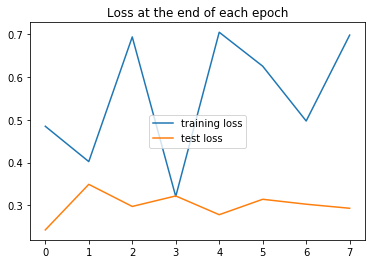

In [46]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend();

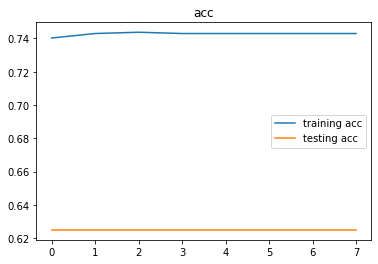

In [47]:
plt.plot([t/float(len(train_data)) for t in train_correct], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct], label='testing acc')
plt.title("acc")
plt.legend()

Test accuracy: 390/624 =  62.500%


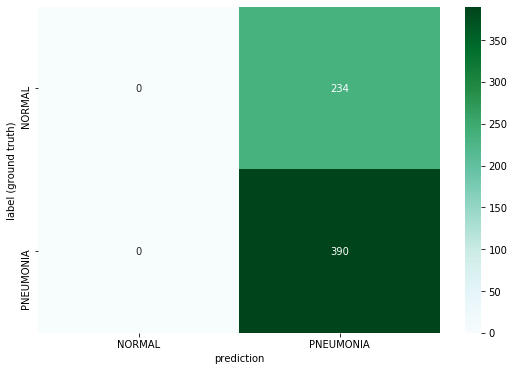

In [48]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
model.eval()
model = model.cpu()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

### Lowering learning rate

By looking at the previous models and their training and testing loss graph we can see that the training loss function is changing sporadically. Typically when we see major changes like those is because the learning rate might be too high so we will lower it to see what we get as a result.

In [49]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=25088, out_features=1028, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1028, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [50]:
train_losses,train_correct,test_losses,test_correct = runModel(model=model,
                                                               criterion=criterion,
                                                               optimizer=optimizer,
                                                               train_loader=train_loader,
                                                               test_loader=test_loader,
                                                               )

epoch:  0  batch:  163 [  2608/5216]  loss: 0.29740226      accuracy:  89.647%
epoch:  0  batch:  326 [  5216/5216]  loss: 0.04360284      accuracy:  91.890%
epoch:  1  batch:  163 [  2608/5216]  loss: 0.11463445      accuracy:  95.207%
epoch:  1  batch:  326 [  5216/5216]  loss: 0.05188814      accuracy:  95.111%
epoch:  2  batch:  163 [  2608/5216]  loss: 0.08681467      accuracy:  95.897%
epoch:  2  batch:  326 [  5216/5216]  loss: 0.04727492      accuracy:  95.916%
epoch:  3  batch:  163 [  2608/5216]  loss: 0.01670191      accuracy:  96.702%
epoch:  3  batch:  326 [  5216/5216]  loss: 0.01802596      accuracy:  96.530%
epoch:  4  batch:  163 [  2608/5216]  loss: 0.06936006      accuracy:  96.281%
epoch:  4  batch:  326 [  5216/5216]  loss: 0.11112017      accuracy:  96.377%
epoch:  5  batch:  163 [  2608/5216]  loss: 0.01735175      accuracy:  97.009%
epoch:  5  batch:  326 [  5216/5216]  loss: 0.11309406      accuracy:  96.952%
epoch:  6  batch:  163 [  2608/5216]  loss: 0.014104

## Analyzing results 3

Now we are seeing better results about 16 to 17 percent accuracy improvement so changing the learning rate was the right step to do. This is clear indicative example of how gradient descent can have many local minima and by changing the learning rate we can land on a better local minima since this is a multidimension model. The best way to show this in a 2D graph is to see the amount of minimas we have.


![title](../images/minima.png)


**In 3D it will be like hitting the pockets in the plane and getting stuck in one without being able to reach the deepest pocket.**

![title](../images/convex_cost_function.jpg)

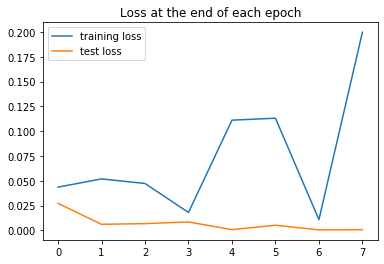

In [52]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend();

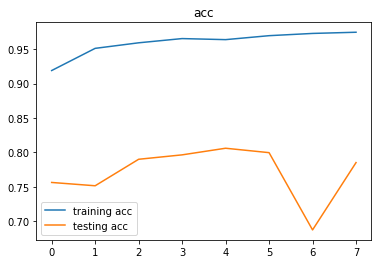

In [53]:
plt.plot([t/float(len(train_data)) for t in train_correct], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct], label='testing acc')
plt.title("acc")
plt.legend()

Test accuracy: 490/624 =  78.526%


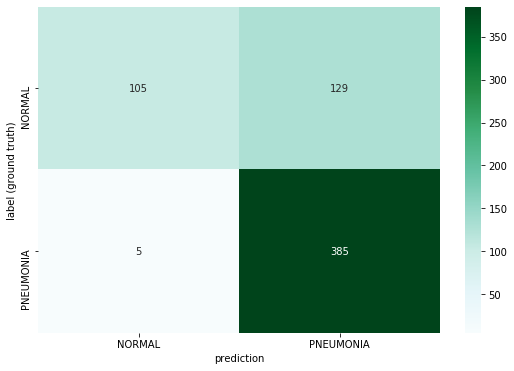

In [54]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
model = model.cpu()
model.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Dropout

Another way to reduce overfitting is though a process called Dropout. It turns off a neuron in the Neural network and makes it so that it is not considered in the feedforward and backpropagation of the model. It randomly chooses all you do is pass how much you want to turn off by giving it a percent. so if you set it to 50%, 50% of the neurons will be picked at random and turned off.

You might wonder why we want to turn off neurons? If they are meant to assist in classifying the data why would we shut it down? Well since the fully connected layer occupies most of the parameters in a CNN, the neurons tend to develop a co-dependency amongst each other during the training process. So some neurons become so important that it skews the favor to this one neuron that is present in the training dataset but not in the testing dataset.

More on dropout: <br>
https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

In [55]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Sequential(nn.Linear(28*28*32, 1028),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(1028, 512),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(512,2))
        

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*32)
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)

In [56]:
model2 = CNN2()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
model2

CNN2(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=25088, out_features=1028, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1028, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [57]:
total=0
for p in model2.parameters():
    total += p.numel()
    print(p.numel())
total

216
8
1152
16
4608
32
25790464
1028
526336
512
1024
2


26325398

In [58]:
train_losses2,train_correct2,test_losses2,test_correct2 = runModel(model=model2,
                                                               criterion=criterion2,
                                                               optimizer=optimizer2,
                                                               train_loader=train_loader,
                                                               test_loader=test_loader,
                                                               )

epoch:  0  batch:  163 [  2608/5216]  loss: 0.18784989      accuracy:  89.110%
epoch:  0  batch:  326 [  5216/5216]  loss: 0.04841678      accuracy:  91.526%
epoch:  1  batch:  163 [  2608/5216]  loss: 0.06553281      accuracy:  94.287%
epoch:  1  batch:  326 [  5216/5216]  loss: 0.12252545      accuracy:  94.670%
epoch:  2  batch:  163 [  2608/5216]  loss: 0.08006792      accuracy:  95.245%
epoch:  2  batch:  326 [  5216/5216]  loss: 0.59418148      accuracy:  95.169%
epoch:  3  batch:  163 [  2608/5216]  loss: 0.08924278      accuracy:  96.012%
epoch:  3  batch:  326 [  5216/5216]  loss: 0.07209798      accuracy:  95.936%
epoch:  4  batch:  163 [  2608/5216]  loss: 0.09488805      accuracy:  96.012%
epoch:  4  batch:  326 [  5216/5216]  loss: 0.01697851      accuracy:  96.031%
epoch:  5  batch:  163 [  2608/5216]  loss: 0.02332749      accuracy:  96.319%
epoch:  5  batch:  326 [  5216/5216]  loss: 0.53742057      accuracy:  96.319%
epoch:  6  batch:  163 [  2608/5216]  loss: 0.053686

## Analyzing results 4

It seems like the dropout function worked and has improved the accuracy by about 3%, the loss trend seems to be running sporadically again so I will lower the learning rate again to see if there is any more improvement to the model.

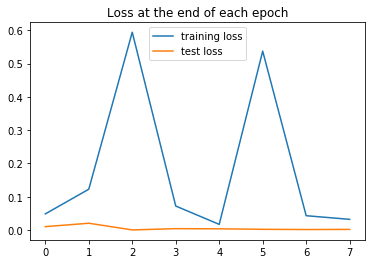

In [59]:
plt.plot(train_losses2, label='training loss')
plt.plot(test_losses2, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

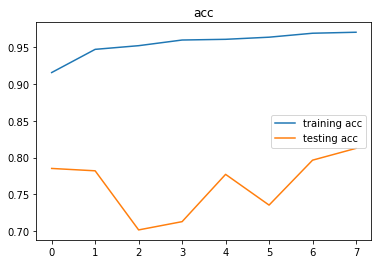

In [60]:
plt.plot([t/float(len(train_data)) for t in train_correct2], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct2], label='testing acc')
plt.title("acc")
plt.legend()

Test accuracy: 507/624 =  81.250%


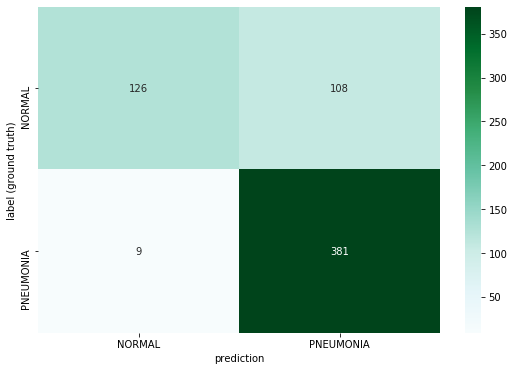

In [61]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
model2 = model2.cpu()
model2.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [111]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

In [112]:
train_losses2,train_correct2,test_losses2,test_correct2 = runModel(model=model2,
                                                               criterion=criterion2,
                                                               optimizer=optimizer2,
                                                               train_loader=train_loader,
                                                               test_loader=test_loader,
                                                               )

epoch:  0  batch:  163 [  2608/5216]  loss: 0.01541655      accuracy:  97.699%
epoch:  0  batch:  326 [  5216/5216]  loss: 0.03413059      accuracy:  97.584%
epoch:  1  batch:  163 [  2608/5216]  loss: 0.00384191      accuracy:  97.853%
epoch:  1  batch:  326 [  5216/5216]  loss: 0.30415469      accuracy:  98.083%
epoch:  2  batch:  163 [  2608/5216]  loss: 0.00576848      accuracy:  98.083%
epoch:  2  batch:  326 [  5216/5216]  loss: 0.09790541      accuracy:  98.025%
epoch:  3  batch:  163 [  2608/5216]  loss: 0.18273084      accuracy:  98.121%
epoch:  3  batch:  326 [  5216/5216]  loss: 0.02787061      accuracy:  98.083%
epoch:  4  batch:  163 [  2608/5216]  loss: 0.07460327      accuracy:  98.313%
epoch:  4  batch:  326 [  5216/5216]  loss: 0.01969333      accuracy:  98.140%
epoch:  5  batch:  163 [  2608/5216]  loss: 0.04717769      accuracy:  98.083%
epoch:  5  batch:  326 [  5216/5216]  loss: 0.00480895      accuracy:  98.255%
epoch:  6  batch:  163 [  2608/5216]  loss: 0.041400

### Further Analysis 4
It seems like lowering the learning rate made it jump to an unwanted local minimum although the losses might look similar. It seems like we heavily overfitted as the training accuracy has reached almost to 99%, so even with 50% neurons turned off at each neuron some became very important and hold a big impact on classifying. Perhaps a bigger network is required or we have to reduce the amount being turn off by 25% instead of 50%.

In [119]:
test_losses2

[tensor(0.0002, device='cuda:0'),
 tensor(4.6785e-05, device='cuda:0'),
 tensor(0.0004, device='cuda:0'),
 tensor(0.0001, device='cuda:0'),
 tensor(0.0002, device='cuda:0'),
 tensor(9.9994e-05, device='cuda:0'),
 tensor(0.0002, device='cuda:0'),
 tensor(0.0002, device='cuda:0')]

In [120]:
train_losses2

[tensor(0.0341, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.3042, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0279, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0079, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.0045, device='cuda:0', grad_fn=<NllLossBackward>)]

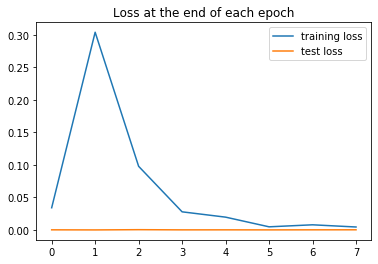

In [122]:
plt.plot(train_losses2, label='training loss')
plt.plot(test_losses2, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

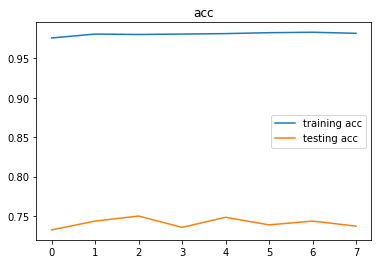

In [117]:
plt.plot([t/float(len(train_data)) for t in train_correct2], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct2], label='testing acc')
plt.title("acc")
plt.legend()

Test accuracy: 460/624 =  73.718%


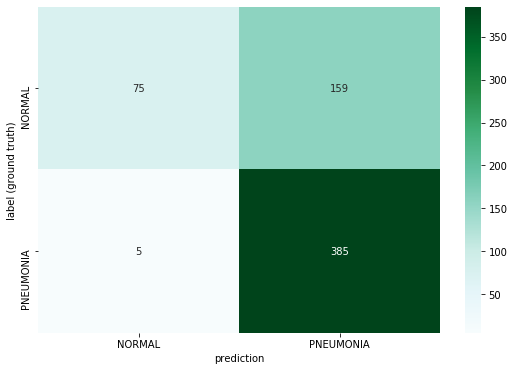

In [118]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
model2 = model2.cpu()
model2.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Batch Normalization

Just like there is normalization in the inputs we can also normalize inside the network. Deep Neural Networks like CNN does suffer from internal covariate shift meaning that the distribution of each layer's inputs changes during training as the parameters of the previous layers changes. So one solution to fix this problem was to perform Batch Normalization before going through the activation function. So Batch normalization computes the mean and standard deviation during training, but during testing Batch Normalization is used across the whole dataset using a moving mean and standard deviation. Batch Normalization has shown a considerable training acceleration to existing architectures. Its weakness is that it does not work well with small batches or non-independent and identically distributed random variables.

More on Batch Normalzation:
https://arthurdouillard.com/post/normalization/
https://arxiv.org/abs/1502.03167

In [104]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Sequential(nn.Linear(28*28*32, 1028),
                                        nn.BatchNorm1d(1028),
                                        nn.ReLU(),
                                        nn.Linear(1028, 512),
                                        nn.BatchNorm1d(512),
                                        nn.ReLU(),
                                        nn.Linear(512,2))
        

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*32)
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)

In [105]:
model3 = CNN3()
criterion3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
model3

CNN3(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=25088, out_features=1028, bias=True)
    (1): BatchNorm1d(1028, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1028, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [106]:
total=0
for p in model3.parameters():
    total += p.numel()
    print(p.numel())
total

216
8
1152
16
4608
32
25790464
1028
1028
1028
526336
512
512
512
1024
2


26328478

In [107]:
train_losses3,train_correct3,test_losses3,test_correct3 = runModel(model=model3,
                                                               criterion=criterion3,
                                                               optimizer=optimizer3,
                                                               train_loader=train_loader,
                                                               test_loader=test_loader,
                                                               )

epoch:  0  batch:  163 [  2608/5216]  loss: 0.07595862      accuracy:  92.983%
epoch:  0  batch:  326 [  5216/5216]  loss: 0.06031073      accuracy:  93.808%
epoch:  1  batch:  163 [  2608/5216]  loss: 0.02306353      accuracy:  94.632%
epoch:  1  batch:  326 [  5216/5216]  loss: 0.06845994      accuracy:  95.035%
epoch:  2  batch:  163 [  2608/5216]  loss: 0.10470048      accuracy:  95.322%
epoch:  2  batch:  326 [  5216/5216]  loss: 0.11259296      accuracy:  95.399%
epoch:  3  batch:  163 [  2608/5216]  loss: 0.08365685      accuracy:  96.204%
epoch:  3  batch:  326 [  5216/5216]  loss: 0.08603802      accuracy:  96.070%
epoch:  4  batch:  163 [  2608/5216]  loss: 0.22874923      accuracy:  96.549%
epoch:  4  batch:  326 [  5216/5216]  loss: 0.08949835      accuracy:  96.396%
epoch:  5  batch:  163 [  2608/5216]  loss: 0.14923406      accuracy:  96.856%
epoch:  5  batch:  326 [  5216/5216]  loss: 0.07203001      accuracy:  96.127%
epoch:  6  batch:  163 [  2608/5216]  loss: 0.352750

## Analysis results 5

It seems like batch normalization was not necessary for this data set has it holds no improvements over the basic neural network. This probably means that the inputs and parameters in the neural network are already normalized so batch normalization causes no changes to the model

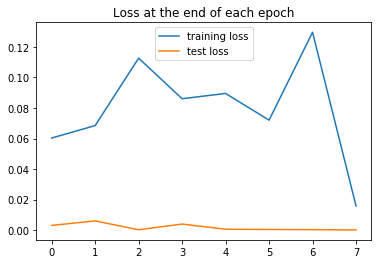

In [108]:
plt.plot(train_losses3, label='training loss')
plt.plot(test_losses3, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend();

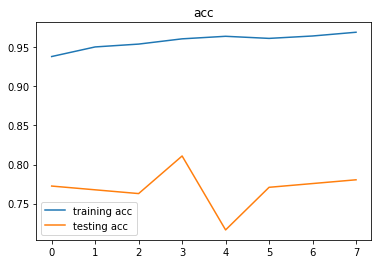

In [109]:
plt.plot([t/float(len(train_data)) for t in train_correct3], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct3], label='testing acc')
plt.title("acc")
plt.legend()

Test accuracy: 487/624 =  78.045%


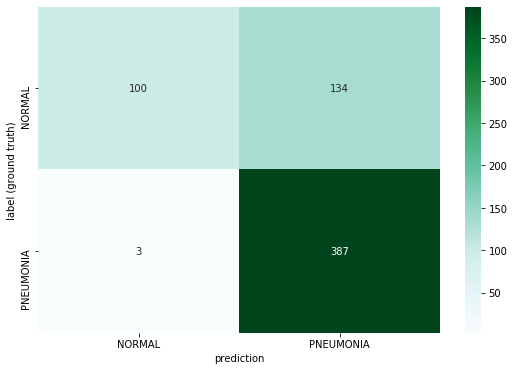

In [110]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
model3 = model3.cpu()
model3.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = model3(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Putting it all together

Now we will perform both the dropout method and batch normalization together to see if we get any improvement in our model.

In [92]:
class CNN4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Sequential(nn.Linear(28*28*32, 1028),
                                        nn.BatchNorm1d(1028),
                                        nn.ReLU(),
                                        nn.Dropout(.5),
                                        nn.Linear(1028, 512),
                                        nn.BatchNorm1d(512),
                                        nn.ReLU(),
                                        nn.Dropout(.5),
                                        nn.Linear(512,2))
        

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*32)
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)

In [93]:
model4 = CNN4()
criterion4 = nn.CrossEntropyLoss()
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.001)
model4

CNN4(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=25088, out_features=1028, bias=True)
    (1): BatchNorm1d(1028, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1028, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [94]:
total=0
for p in model4.parameters():
    total += p.numel()
    print(p.numel())
total

216
8
1152
16
4608
32
25790464
1028
1028
1028
526336
512
512
512
1024
2


26328478

In [95]:
train_losses4,train_correct4,test_losses4,test_correct4 = runModel(model=model4,
                                                               criterion=criterion4,
                                                               optimizer=optimizer4,
                                                               train_loader=train_loader,
                                                               test_loader=test_loader,
                                                               )

epoch:  0  batch:  163 [  2608/5216]  loss: 0.29680669      accuracy:  92.293%
epoch:  0  batch:  326 [  5216/5216]  loss: 0.12984005      accuracy:  92.446%
epoch:  1  batch:  163 [  2608/5216]  loss: 0.16685461      accuracy:  94.670%
epoch:  1  batch:  326 [  5216/5216]  loss: 0.03947050      accuracy:  94.881%
epoch:  2  batch:  163 [  2608/5216]  loss: 0.11961618      accuracy:  94.363%
epoch:  2  batch:  326 [  5216/5216]  loss: 0.02601286      accuracy:  94.785%
epoch:  3  batch:  163 [  2608/5216]  loss: 0.24648839      accuracy:  94.977%
epoch:  3  batch:  326 [  5216/5216]  loss: 0.01863664      accuracy:  95.667%
epoch:  4  batch:  163 [  2608/5216]  loss: 0.20901106      accuracy:  95.706%
epoch:  4  batch:  326 [  5216/5216]  loss: 0.21230467      accuracy:  95.686%
epoch:  5  batch:  163 [  2608/5216]  loss: 0.04802736      accuracy:  95.897%
epoch:  5  batch:  326 [  5216/5216]  loss: 0.04264546      accuracy:  95.936%
epoch:  6  batch:  163 [  2608/5216]  loss: 0.073587

## Analysis result 6

With both dropout and batch normalization we can see that the model still shows sign of overfitting but the losses don't have such a big gap. Although the performance increase by a small percentage, about 1-2%, it still improvement over the previous model. The closer we get to 99% the better it is since we want to reach this number and then it might be considered to be used in real life applications.

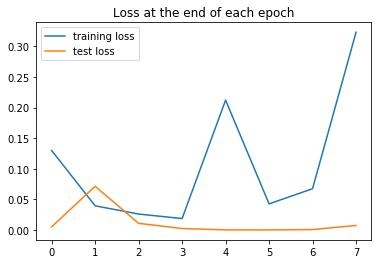

In [96]:
plt.plot(train_losses4, label='training loss')
plt.plot(test_losses4, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend();

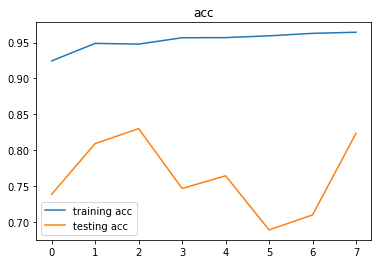

In [97]:
plt.plot([t/float(len(train_data)) for t in train_correct4], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct4], label='testing acc')
plt.title("acc")
plt.legend()

Test accuracy: 514/624 =  82.372%


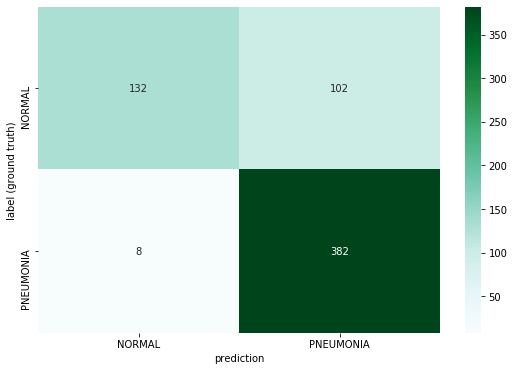

In [98]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
model4 = model4.cpu()
model4.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = model4(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

**We have seem to reach a road block in our models, it seems like we cannot get past the 80s% accuracy rate and we think it might be due to lack of data so we will manipulate the data we already have and increase the training dataset.**

In [149]:
train_transform1 = transforms.Compose([
        transforms.RandomRotation(25),      # rotate +/- 25 degrees
        transforms.RandomHorizontalFlip(1),  # reverse 100% of images
        transforms.Resize(244),             # resize shortest side to 224 pixels
        transforms.CenterCrop(244),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

train_transform2 = transforms.Compose([
        transforms.RandomRotation(25),      # rotate +/- 25 degrees
        transforms.RandomHorizontalFlip(0), 
        transforms.Resize(244),             # resize shortest side to 224 pixels
        transforms.CenterCrop(244),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [150]:
train_data1 = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transform1)
train_data2 = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transform2)
t = []
t.append(train_data1)
t.append(train_data2)

In [151]:
t

[Dataset ImageFolder
     Number of datapoints: 5216
     Root location: ../Data/chest_xray/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=(-25, 25), resample=False, expand=False)
                RandomHorizontalFlip(p=1)
                Resize(size=244, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(244, 244))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 5216
     Root location: ../Data/chest_xray/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=(-25, 25), resample=False, expand=False)
                RandomHorizontalFlip(p=0)
                Resize(size=244, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(244, 244))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )]

In [152]:
concat_data = ConcatDataset(t)

In [153]:
concat_loader = DataLoader(concat_data,batch_size=16,shuffle=True, pin_memory=True)

In [154]:
len(concat_loader)

652

In [155]:
class CNN5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Sequential(nn.Linear(28*28*32, 1028),
                                        nn.BatchNorm1d(1028),
                                        nn.ReLU(),
                                        nn.Dropout(.5),
                                        nn.Linear(1028, 512),
                                        nn.BatchNorm1d(512),
                                        nn.ReLU(),
                                        nn.Dropout(.5),
                                        nn.Linear(512,2))
        

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*32)
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)

In [157]:
model5 = CNN5()
criterion5 = nn.CrossEntropyLoss()
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.001)
model5

CNN5(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=25088, out_features=1028, bias=True)
    (1): BatchNorm1d(1028, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1028, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [158]:
train_losses5,train_correct5,test_losses5,test_correct5 = runModel(model=model5,
                                                               criterion=criterion5,
                                                               optimizer=optimizer5,
                                                               train_loader=concat_loader,
                                                               test_loader=test_loader,
                                                               c=2)

epoch:  0  batch:  163 [  2608/10432]  loss: 0.49822724      accuracy:  90.606%
epoch:  0  batch:  326 [  5216/10432]  loss: 0.05697343      accuracy:  91.526%
epoch:  0  batch:  489 [  7824/10432]  loss: 0.05451965      accuracy:  92.140%
epoch:  0  batch:  652 [ 10432/10432]  loss: 0.32243338      accuracy:  92.811%
epoch:  1  batch:  163 [  2608/10432]  loss: 0.31754714      accuracy:  94.594%
epoch:  1  batch:  326 [  5216/10432]  loss: 0.29321456      accuracy:  94.574%
epoch:  1  batch:  489 [  7824/10432]  loss: 0.17821366      accuracy:  94.351%
epoch:  1  batch:  652 [ 10432/10432]  loss: 0.14633282      accuracy:  94.546%
epoch:  2  batch:  163 [  2608/10432]  loss: 0.06500145      accuracy:  94.862%
epoch:  2  batch:  326 [  5216/10432]  loss: 0.22214967      accuracy:  95.073%
epoch:  2  batch:  489 [  7824/10432]  loss: 0.06959419      accuracy:  95.156%
epoch:  2  batch:  652 [ 10432/10432]  loss: 0.01427353      accuracy:  95.054%
epoch:  3  batch:  163 [  2608/10432]  l

## Analysis result 7

Even with more data used for training the model has to improve at all and it actually got worst at the end. Although at some point it reach the same accuracy of the previous model,. So it seems that with the current model we have it has reached its maximum capacity of learning without any further changes. I think is very possible to reach higher accuracy with a more complex model. Although this is a Deep Neural Network I think this is considered a shallow neural network in today's standards, meaning that it's actually not a very complex model.

We will further test more models by using a larger and more complex model known as AlexNet from ImageNet.

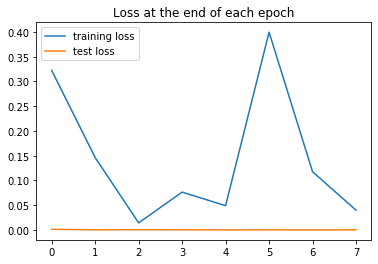

In [159]:
plt.plot(train_losses5, label='training loss')
plt.plot(test_losses5, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [183]:
for t in test_correct5:
    print(t/float(len(test_data)))

tensor(0.7917, device='cuda:0')
tensor(0.7212, device='cuda:0')
tensor(0.7740, device='cuda:0')
tensor(0.7596, device='cuda:0')
tensor(0.7196, device='cuda:0')
tensor(0.7788, device='cuda:0')
tensor(0.8029, device='cuda:0')
tensor(0.7340, device='cuda:0')


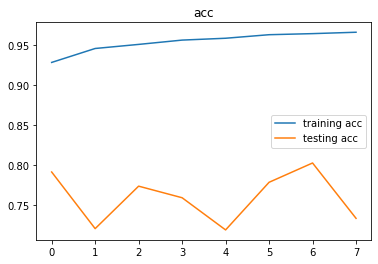

In [169]:
plt.plot([t/float(len(concat_data)) for t in train_correct5], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct5], label='testing acc')
plt.title("acc")
plt.legend()

Test accuracy: 458/624 =  73.397%


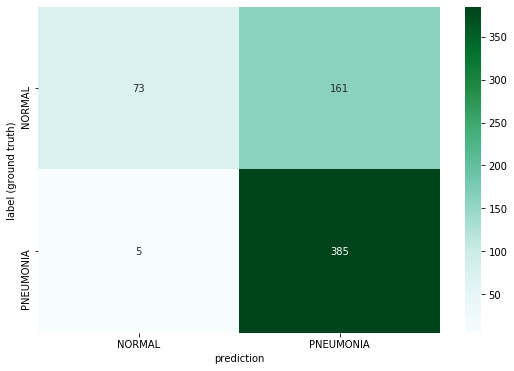

In [182]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
model5 = model5.cpu()
model5.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = model5(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## ImageNet

Convolutional Neural Networks (CNNs) models are commonly used for object recognition. Advances in Artificial intelligence are reflected in the compilation of publicly available datasets like ImageNet. ImageNet contains more than 15 million high-resolution labeled images into 22 thousand classes. CNNs are hard to apply to high-resolution images; it requires a significant amount of computational power and time. AlexNet is the name of a CNN designed by Alex Krizhevsky winner of the ImageNet Large Scale Visual Recognition Challenge on September 30 of the year 2012. AlexNet showed a vast improvement over other participant networks by making use of GPUs during training. AlexNet won the 2012 ImageNet competition with a top-5 error rate of 15.3%, compared to the second-place top-5 error rate of 26.2%. The architecture consists of five convolutional layers and three fully connected layers. Also, the use of the ReLu (Rectified Linear Units) instead of the standard tahn function made it possible to reach a 25% error six times faster than a CNN using the than function. The use of multiple GPUs is a key feature in AlexNet. Training half of the model’s neurons in one GPU and the other half on another GPU makes it possible to train a larger set and cut the time in half. AlexNet architecture is a leading model in object detection showing huge potential in computer vision.

More on ImageNet: <br>
https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951 <br>
https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf <br>
https://en.wikipedia.org/wiki/Convolutional_neural_network <br>
https://en.wikipedia.org/wiki/AlexNet <br>

### Transfer learning
Transfer learning is a machine learning method where a model developed for a similar task is reused as the starting point for a model on a second task. It allows rapid progress or improved performance when applied to the second task. For transfer learning, the features used on the first task must be general so that they are suitable for the second task. An example of transfer learning is the use of a pre-trained model for a large challenging image classification task like the ImageNet 100-class photograph classification competition. These models can be downloaded and integrated into new models that expect image data as input. Transfer learning is a shortcut or optimization to saving time or benefiting from the performance of the reused model. A common usage pattern for transfer learning is the classifier where the pre-trained model is used directly to classify new images.

More on transfer learning: <br>
https://machinelearningmastery.com/transfer-learning-for-deep-learning/
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

#### Steps for transfer learning
* We will be performing transfer learning by first loading the model and grabbing its pretrained weights.
* Then we will freeze all the convolutional layers.
* Then we will replace the fully connected layer thats on the pre-loaded AlexNet model to fit it to our dataset.

In [185]:
alexNet = models.alexnet(pretrained=False) # loading the AlexNet model 

In [186]:
for param in alexNet.features.parameters(): # freezing all layers so no learning is required in the convolutional section
    param.require_grad = False

In [187]:
alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [188]:
alexNet.classifier = nn.Sequential(nn.Linear(9216, 4096), # Got to keep the flatten input features, in this case 9261
                                 nn.ReLU(),
                                 nn.Dropout(.5),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(.5),
                                 nn.Linear(4096,2))

In [189]:
alexNet
criterion6 = nn.CrossEntropyLoss()
optimizer6 = torch.optim.Adam(alexNet.parameters(), lr=0.001)

In [190]:
train_losses6,train_correct6,test_losses6,test_correct6 = runModel(model=alexNet,
                                                               criterion=criterion6,
                                                               optimizer=optimizer6,
                                                               train_loader=train_loader,
                                                               test_loader=test_loader,
                                                               c=2)

epoch:  0  batch:  163 [  2608/10432]  loss: 0.25926328      accuracy:  85.621%
epoch:  0  batch:  326 [  5216/10432]  loss: 0.29073182      accuracy:  88.842%
epoch:  1  batch:  163 [  2608/10432]  loss: 0.35466045      accuracy:  93.788%
epoch:  1  batch:  326 [  5216/10432]  loss: 0.37027159      accuracy:  94.402%
epoch:  2  batch:  163 [  2608/10432]  loss: 0.00465753      accuracy:  95.360%
epoch:  2  batch:  326 [  5216/10432]  loss: 0.02269708      accuracy:  95.399%
epoch:  3  batch:  163 [  2608/10432]  loss: 0.01041041      accuracy:  95.744%
epoch:  3  batch:  326 [  5216/10432]  loss: 0.01745646      accuracy:  96.300%
epoch:  4  batch:  163 [  2608/10432]  loss: 0.02433774      accuracy:  96.779%
epoch:  4  batch:  326 [  5216/10432]  loss: 0.01053682      accuracy:  96.856%
epoch:  5  batch:  163 [  2608/10432]  loss: 0.16332653      accuracy:  96.357%
epoch:  5  batch:  326 [  5216/10432]  loss: 0.38719887      accuracy:  96.415%
epoch:  6  batch:  163 [  2608/10432]  l

## Analyzing results 8

It seems like the pre-made model performs about the same as our model. This brings me to believe that our dataset is not diverse enough for it to be trained in a model to reach high accuracy. It seems to always do well in the training accuracy but its learning too much of a feature in there. I believe that the accuracy can be easily increased if we had either more data(images) or more data correlating to Pneumonia. In this case, we would need a new type of model that takes both image data and clinical data.

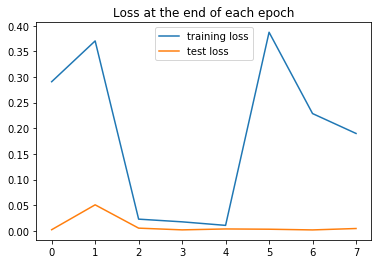

In [191]:
plt.plot(train_losses6, label='training loss')
plt.plot(test_losses6, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [195]:
for t in test_correct6:
    print(t/float(len(test_data)))

tensor(0.7196, device='cuda:0')
tensor(0.7949, device='cuda:0')
tensor(0.7676, device='cuda:0')
tensor(0.7756, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8173, device='cuda:0')
tensor(0.7853, device='cuda:0')
tensor(0.7692, device='cuda:0')


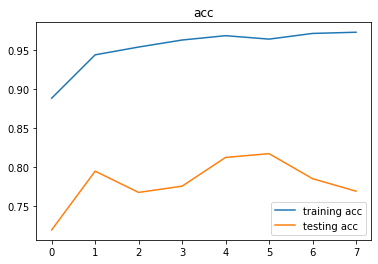

In [192]:
plt.plot([t/float(len(train_data)) for t in train_correct6], label='training acc')
plt.plot([t/float(len(test_data)) for t in test_correct6], label='testing acc')
plt.title("acc")
plt.legend()

Test accuracy: 480/624 =  76.923%


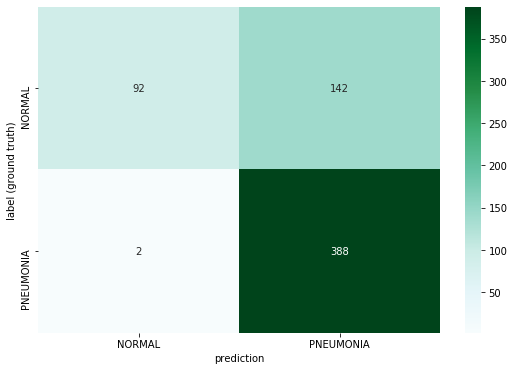

In [193]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=624, shuffle=False)
alexNet = alexNet.cpu()
alexNet.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
             
        y_val = alexNet(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

# Conclusion

In this project, we have introduced the basic process of Deep Neural Networks for image processing. We have used the power of the Convolution Neural Network to try and classify medical images to see if it can tell the difference between a Normal or Pneumonia x-ray. 

To recap we have study about what makes a Fully Connected Convolutional Neural Network which is the Convolutional Layers that consist of mathematical computation using Convolution and Max Pooling. After the Convolutional Layer, we have the Fully Connected Layer that grabs the input from the Convolutional Layer and then feed forward the information through the hidden layer to give a classification in the output layer.

Through all these layers we have an activation function that is mathematical equations applied to each neuron to produce an output. Though the output layer uses the softmax function that converts the output layer to a probability vector that ranges from 0 to 1 and the sum of the vector should be 1. Then we have other functions to move through gradient descent smoothly that is known as the Loss Function and the Optimizer, these two operate hand in hand to achieve a minimum for our multidimensional classification.

Then when experiencing overfitting, which is when our model learns too much from our training dataset and does not perform when new data is thrown at it. To reduce overfitting we use approaches like Dropout, Normalization, increasing learning rate, and more varying data.

Finally, we finished it off with a Deep Learning approach call transfer learning. This where we use a pre-made model and change the fully connected layer to our needs. In turn, we need to also make sure our data has the same properties as it was trained, we did this by changing the image size to at least 224 by 244 and normalizing the images with ImageNet's Mean and Standard deviation. 

Through this project we found it very interesting that A Convolutional Neural Network can classify these two classes. Seeing as we are not medical professional we can not identify any problems whatsoever from these images but the CNN model is actually picking up features that. 

One of the most difficult problem as a beginner is trying to figure out what parameters to change to reduce overfitting since it takes about 15 to 30 minute to train each model with just 8 epochs every parameter we change have to have a solid reason has time is wasted during this. We can't imagine how this works with heavier and complex models as those might take even longer to converge to an answer. 

We believe that for this level of work the best way to improve the models are two things. Be able to dynamically change the learning rate as the models is being train and also recording the model with the best results. Many times we see in the graph that a high point of accuracy has been reach but was discarded since it went trough another epoch of training. Also there were alot of sporodic changes in the loss function and accuracy that leads us to believe is because after training a certain amount the learning rate is too high and not converge correctly